## Research Team Tools

In [1]:

# Python Imports
from typing import List, Dict

# Optimization Imports
from concurrent.futures import ThreadPoolExecutor
from backend.src.tools.datatracker import get_company_by_url
from functools import lru_cache
import asyncio

# Local imports
from backend.src.tools.vector_store import VectorStoreManager
from backend.src.tools.grader import Grader


from langchain_core.tools import tool


# temp
import os
os.environ["LANGCHAIN_TRACING_V2"] = "false"

# Cache expensive operations
@lru_cache(maxsize=100)
def get_cached_db_status(url: str):
    """Cache database status checks to avoid repeated lookups"""
    return get_company_by_url(url)

# Thread pool for I/O operations
executor = ThreadPoolExecutor(max_workers=4)

def fetch_web_data_to_db_async(url: str):
    """Non-blocking version of web data fetching"""

    def _fetch():
        vectorstore = VectorStoreManager()
        loop = asyncio.new_event_loop()
        asyncio.set_event_loop(loop)
        return loop.run_until_complete(vectorstore.proto_add_final(url))

    return executor.submit(_fetch)


def retrieve_and_grade(query: str, is_preference_data: bool = False, metadata: Dict[str, str] = None)-> List[Dict]:
    """Retrieves chunks for a query and grades them for relevance, completeness, and faithfulness."""
    vectorstore = VectorStoreManager()
    grader = Grader()

    if is_preference_data:
        retrieved_chunks = vectorstore.vectordb_query_filtering(query, metadata)
    else:
        retrieved_chunks = vectorstore.vectordb_query_chatbot(query = query, metadata_filter = metadata)

    # Extract only the page_content to feed into the grader
    chunk_texts = [doc.page_content for doc in retrieved_chunks]

    # Grade the extracted texts
    grade_report = grader.CompositeGrader(chunk_texts, query)



    # merge the mean chunk quality score in the chunk document
    for chunk in retrieved_chunks:
        chunk.metadata["retrieval_quality_score"] = grade_report


    return retrieved_chunks


@tool
def retriever(query: str, ispreferencedata: bool = False, metadata: Dict[str, str] = None) -> List[Dict]:
    """
    🚀 OPTIMIZED: Faster retrieval with caching and limits
    """
    vectorstore = VectorStoreManager()

    # 🚀 OPTIMIZATION 3: Limit results for faster processing
    if ispreferencedata:
        retrieved_chunks = vectorstore.vectordb_query_filtering(query, metadata)
    else:
        retrieved_chunks = vectorstore.vectordb_query_chatbot(query)

    # Limit to top 5 results for faster processing
    return retrieved_chunks

# Cached status check
def check_db(url: str):
    return get_cached_db_status(url)


Using local credentials.
Using local credentials.


/Users/mohammedansari/Desktop/clausebit/.venv/lib/python3.13/site-packages/vertexai/_model_garden/_model_garden_models.py:278: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()


## State Setup

In [2]:
# Multi agent setup imports
from langgraph.graph import add_messages
from langchain_core.messages import BaseMessage
from pydantic import BaseModel

# Python Imports
from typing import Annotated
from typing import List, Optional, Dict, Any



class ClauseBitState(BaseModel):
    messages: Annotated[List[BaseMessage], add_messages]
    user_preferences: Optional[Dict[str, Any]] = None
    current_url: Optional[str] = None
    current_query: Optional[str] = None





## Utilities
### Setup for the supervisor node

In [3]:
from typing import TypedDict, Literal
from langchain_core.messages import AIMessage
from langchain_core.language_models.chat_models import BaseChatModel


def make_supervisor_node(llm: BaseChatModel, members: list[str]):
    options = ["FINISH"] + members

    def supervisor_node(state: ClauseBitState) -> str:
        if not isinstance(state.messages[-1], HumanMessage):
            return "FINISH"

        # The last question asked
        user_question = state.messages[-1].content.lower().strip()

        print("[Supervisor received message]:", user_question)

         # OPTIMIZATION 5: Fast keyword-based routing (skip LLM for obvious cases)
        conversation_keywords = [
            "what was the last question", "what did i ask", "previous question",
            "last time", "before", "earlier", "conversation history"
        ]

        if any(keyword in user_question for keyword in conversation_keywords):
            return "llm_answer"



        # OPTIMIZATION: Async scraping (non-blocking)
        db_status = get_cached_db_status(state.current_url)


        if db_status == False:

            print("🚀 Starting async scraping...")
            # Start scraping in background
            fetch_web_data_to_db_async(state.current_url)

            # For now, return scraping is in progress
            return "scraping_in_progress"

        if db_status["found_data"] is False:
            return  "llm_answer"

        system_prompt = (
            "You are a supervisor agent managing a conversation with access to two workers: `search` and `llm_answer`.\n\n"
            "• If the user asks a general-purpose or factual question that can be answered by a language model (e.g., 'What are cookies?', 'Is GitHub a known company?'), route to `llm_answer`.\n"
            "• If the user asks something that requires information from a specific website's legal documents (e.g., Privacy Policy or Terms of Service), route to `search`.\n"
        )

        class Router(TypedDict):
            next: Literal[*options]


        recent_messages = state.messages
        formatted_messages = []
        for msg in recent_messages:
            if isinstance(msg, HumanMessage):
                formatted_messages.append({"role": "user", "content": msg.content})
            elif isinstance(msg, AIMessage):
                formatted_messages.append({"role": "assistant", "content": msg.content})

        messages = [{"role": "system", "content": system_prompt}] + formatted_messages
        response = llm.with_structured_output(Router).invoke(messages)
        print("[Supervisor routed to]:", response)

        goto = response["next"]
        if goto == "FINISH":
            return "FINISH"
        if goto not in members and goto != "FINISH":
            print(f"[Invalid route '{goto}'], routing to llm_answer")
            return "llm_answer"

        return goto

    return supervisor_node



In [4]:
from backend.src.agents.supervisor_agent import extract_email
from langchain_google_vertexai import ChatVertexAI
from backend.auth.init_vertex import init_vertex_ai
from langchain_core.messages import HumanMessage

init_vertex_ai()

llm = ChatVertexAI(
    model="gemini-2.5-pro",
    temperature=0.3,  # Lower temperature for faster, more deterministic responses
    max_output_tokens=1500  # Reduced from 3000 for faster generation
)



def search_node(state: ClauseBitState) -> ClauseBitState:
    """Search node with timeout and result limiting"""
    try:

        print("Using Search Agent....")


        user_question = state.messages[-1].content.lower().strip()
        url_check = extract_email(user_question)

        if url_check:
            state.current_url = url_check


        metadata = {"domain":state.current_url}
        print(metadata)
        print(f"current qurstion {user_question}")
        context = retrieve_and_grade(query = user_question, metadata =metadata )


        full_prompt = (
            f"{context}\nCurrent question: {user_question}\n\nProvide a concise, helpful response in a chat format."
            f"Do not include:  Markdown formatting (like **bold**, bullet points, or headings ")
        print(f"Using LLM Node:{full_prompt}")
        llm_response = llm.invoke(full_prompt)
        response_content = llm_response.content

        new_message = AIMessage(content=response_content, name="search")

        return ClauseBitState(
            messages=state.messages + [new_message],
            user_preferences=state.user_preferences,
            current_url=state.current_url,
            current_query=state.current_query,

        )
    except Exception as e:
        # Quick fallback on search failure
        error_msg = AIMessage(content=f"Search temporarily unavailable. Error: {str(e)[:100]}", name="search")
        return ClauseBitState(
            messages=state.messages + [error_msg],
            user_preferences=state.user_preferences,
            current_url=state.current_url,
            current_query=state.current_query,
        )


def llm_answer_node(state: ClauseBitState) -> ClauseBitState:
    """ Faster LLM responses with shorter context"""
    current_question =state.messages[-1]
    context = state.messages

    full_prompt = f"{context}\nCurrent question: {current_question}\n\nProvide a concise, helpful response under 100 words."
    print(f"Using LLM Node:{full_prompt}")
    llm_response = llm.invoke(full_prompt)
    response_content = llm_response.content

    new_message = AIMessage(content=response_content, name="llm_answer")

    return ClauseBitState(
        messages=state.messages + [new_message],
        user_preferences=state.user_preferences,
        current_url=state.current_url,
        current_query=state.current_query,
    )

def scraping_in_progress_node(state: ClauseBitState) -> ClauseBitState:
    """ Handle scraping in progress scenario"""
    msg = AIMessage(
        content="🔄 I'm currently analyzing this website's documents. This may take a moment. "
                "Meanwhile, I can answer general questions or you can try your document query again in a few seconds.",
        name="scraping_status"
    )

    return ClauseBitState(
        messages=state.messages + [msg],
        user_preferences=state.user_preferences,
        current_url=state.current_url,
        current_query=state.current_query,
    )

def error_handler_node(state: ClauseBitState) -> ClauseBitState:
    """Handle errors and edge cases"""
    if not state.current_url:
        error_msg = AIMessage(content="No URL provided. Cannot proceed.")
    else:
        db_status = get_cached_db_status(state.current_url)
        if db_status and db_status.get("found_data") is False:
            error_msg = AIMessage(
                content="I can't answer questions for this company — no useful data was found during scraping.")
        else:
            error_msg = AIMessage(content="An error occurred while processing your request.")

    return ClauseBitState(
        messages=state.messages + [error_msg],
        user_preferences=state.user_preferences,
        current_url=state.current_url,
        current_query=state.current_query,
    )



Using local credentials.


In [13]:
from langgraph.graph import StateGraph, END
from typing import Tuple

# Create supervisor node
research_supervisor_node = make_supervisor_node(
    llm,
    ["search", "llm_answer", "scraping_in_progress"]
)

# Route decisions made by supervisor
def route_supervisor_decision(state: ClauseBitState):
    """Route based on supervisor's decision"""
    return research_supervisor_node(state)


# scraping_in_progress_node returns ("supervisor", updated_state)
def scraping_in_progress_node(state: ClauseBitState) -> Tuple[str, ClauseBitState]:
    msg = AIMessage(
        content=(
            "🔄 I'm currently analyzing this website's documents. "
            "Please wait a moment. Meanwhile, you can ask general questions or retry shortly."
        ),
        name="scraping_status"
    )

    updated_state = ClauseBitState(
        messages=state.messages + [msg],
        user_preferences=state.user_preferences,
        current_url=state.current_url,
        current_query=state.current_query,

    )

    return "supervisor", updated_state


# Build the LangGraph
graph = StateGraph(ClauseBitState)

# Add nodes
graph.add_node("supervisor", lambda state: state)
graph.add_node("search", search_node)
graph.add_node("llm_answer", llm_answer_node)
graph.add_node("scraping_in_progress", scraping_in_progress_node)
graph.add_node("error_handler", error_handler_node)
graph.add_node("finish", lambda state: state)

# Set entry point
graph.set_entry_point("supervisor")

# Route decisions made by supervisor
graph.add_conditional_edges(
    "supervisor",
    route_supervisor_decision,
    {
        "search": "search",
        "llm_answer": "llm_answer",
        "scraping_in_progress": "scraping_in_progress",
        "FINISH": "finish",
        "error": "error_handler"
    }
)

# Normal execution goes to END
graph.add_edge("search", END)
graph.add_edge("llm_answer", END)
graph.add_edge("error_handler", END)
graph.add_edge("finish", END)

#  Loop: scraping → supervisor (via routing tag)
graph.add_conditional_edges(
    "scraping_in_progress",
    lambda result: result[0],  # get tag from ("supervisor", updated_state)
    {
        "supervisor": "supervisor"
    }
)

# Compile
research_graph = graph.compile()


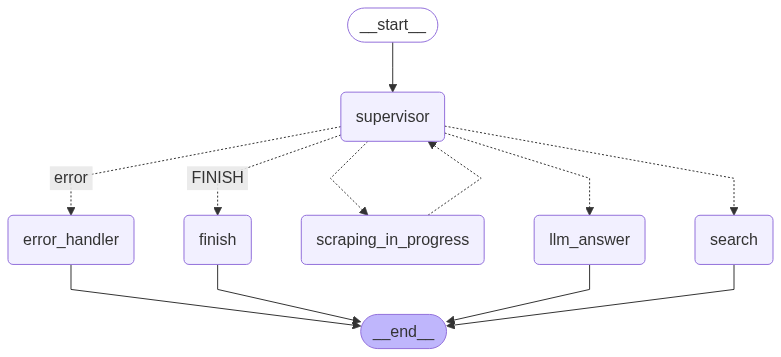

In [14]:
from IPython.display import Image, display

display(Image(research_graph.get_graph().draw_mermaid_png()))

In [7]:



def chat():
    print("🚀 ClauseBit (Optimized): Hello! I can help you analyze legal documents quickly.")
    print("Type 'quit', 'exit', or 'bye' to end the conversation.\n")

    url = input("🔗 Enter URL to analyze (or press Enter for default GitHub): ").strip()
    if not url:
        url = "https://github.com/"

    print(f"📄 Analyzing: {url}\n")

    conversation_messages = []

    while True:
        try:
            inp = input("👤 You: ").strip()

            if inp.lower() in ['quit', 'exit', 'bye', 'stop']:
                print("🚀 ClauseBit: Goodbye! 👋")
                break

            if not inp:
                print("🚀 ClauseBit: Please enter a question or type 'quit' to exit.")
                continue



            user_msg = HumanMessage(content=inp)
            conversation_messages.append(user_msg)

            state = ClauseBitState(messages=conversation_messages, current_url=url)
            result = research_graph.invoke(state)

            msgs = result["messages"]
            last_ai_messages = [m for m in msgs if isinstance(m, AIMessage)]

            if last_ai_messages:
                response = last_ai_messages[-1].content

                print(f"🚀 ClauseBit: {response}")
                conversation_messages.append(AIMessage(content=response))
            else:
                print("🚀 ClauseBit: (no response)")

            print()

        except KeyboardInterrupt:
            print("\n🚀 ClauseBit: Goodbye! 👋")
            break
        except Exception as e:
            print(f"🚀 ClauseBit: Sorry, an error occurred: {str(e)}")
            print("Please try again or type 'quit' to exit.\n")


In [8]:
chat()

🚀 ClauseBit (Optimized): Hello! I can help you analyze legal documents quickly.
Type 'quit', 'exit', or 'bye' to end the conversation.



KeyboardInterrupt: Interrupted by user